In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
mpl.rcParams['figure.dpi'] = 150
from matplotlib import pyplot as plt
import pandas as pd
from astropy.io import fits
import h5py
from tqdm import tqdm

from astropy.cosmology import Planck18
cosmo = Planck18

In [2]:
from omegaconf import OmegaConf
from cmass.infer.loaders import get_cosmo
from cmass.survey.tools import sky_to_xyz
from cmass.survey.tools import in_simbig_selection
cosmo = Planck18

# wdir = '/ocean/projects/phy240015p/mho1/cmass-ili'
wdir = '/anvil/scratch/x-mho1/cmass-ili'

# nbody = 'quijote'
# sim = 'randoms'
# tracer = 'simbig_lightcone'
# L, N = 1000, 128
# lhid = 4  # 663
# hodseed = 0

# nbody = 'abacus'
# sim = 'randoms'
# tracer = 'sgc_lightcone'
# tracer = 'mtng_lightcone'
# # tracer = 'simbig_lightcone'
# L, N = 2000, 256
# lhid = 0  # 663
# hodseed = 0

nbody = 'quijote3gpch'
sim = 'randoms'
tracer = 'ngc_lightcone'
L, N = 3000, 384
lhid = 0  # 663
hodseed = 0

simdir = join(wdir, nbody, sim, f'L{L:d}-N{N:d}', str(lhid))

# cosmo = get_cosmo(simdir)
cfg = OmegaConf.load(join(simdir, 'config.yaml'))

In [ ]:
# Load observations
from cmass.survey.tools import apply_mask


def load_fits(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)
    return gals


zlim = 0.4, 0.7
fields = ['RA', 'DEC', 'Z', 'WEIGHT_SYSTOT', 'WEIGHT_NOZ', 'WEIGHT_CP']

if tracer in ['simbig_lightcone', 'sgc_lightcone']:
    # Load SGC
    fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_South.fits')
    cmass = load_fits(fname, fields)
    srdz = cmass[['RA', 'DEC', 'Z']].values
    mask = (srdz[:, 2] > zlim[0]) & (srdz[:, 2] < zlim[1])
    srdz = srdz[mask]

    # srdz = apply_mask(srdz, wdir, is_North=True, fibermode=1)

    if tracer == 'simbig_lightcone':
        # apply simbig selection
        mask = in_simbig_selection(srdz[:, 0], srdz[:, 1], srdz[:, 2])
        srdz = srdz[mask]
elif tracer == 'ngc_lightcone':
    # Load NGC
    fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_North.fits')
    cmass = load_fits(fname, fields)
    nrdz = cmass[['RA', 'DEC', 'Z']].values
    mask = (nrdz[:, 2] > zlim[0]) & (nrdz[:, 2] < zlim[1])
    nrdz = nrdz[mask]

    # nrdz = apply_mask(nrdz, wdir, is_North=True, fibermode=1)

    srdz = nrdz
elif tracer == 'mtng_lightcone':
    fname = join(
        wdir, 'mtng/nbody/L3000-N384/0/mtng_lightcone/hod00000_aug00000.h5')
    with h5py.File(fname, 'r') as f:
        ra, dec, z = f['ra'][:], f['dec'][:], f['z'][:]
    srdz = np.stack((ra, dec, z), axis=-1)


print(srdz.min(axis=0), '\n', srdz.max(axis=0))
sxyz = sky_to_xyz(srdz, cosmo)

[108.93713069  -3.60815258   0.40001616] 
 [263.90750667  68.73769854   0.69999975]


In [46]:
# load lightcone
filename = join(simdir, tracer, f'hod{hodseed:05}_aug{0:05d}.h5')

with h5py.File(filename, 'r') as f:
    ra, dec, z = f['ra'][:], f['dec'][:], f['z'][:]
    rdz = np.stack((ra, dec, z), axis=-1)
xyz = sky_to_xyz(rdz, cosmo)
# xyz = xyz[xyz[:, -1] < 1000]

print(rdz.min(axis=0), '\n', rdz.max(axis=0))

[109.07093029  -3.58135822   0.4000028 ] 
 [263.68791398  68.66755715   0.69999795]


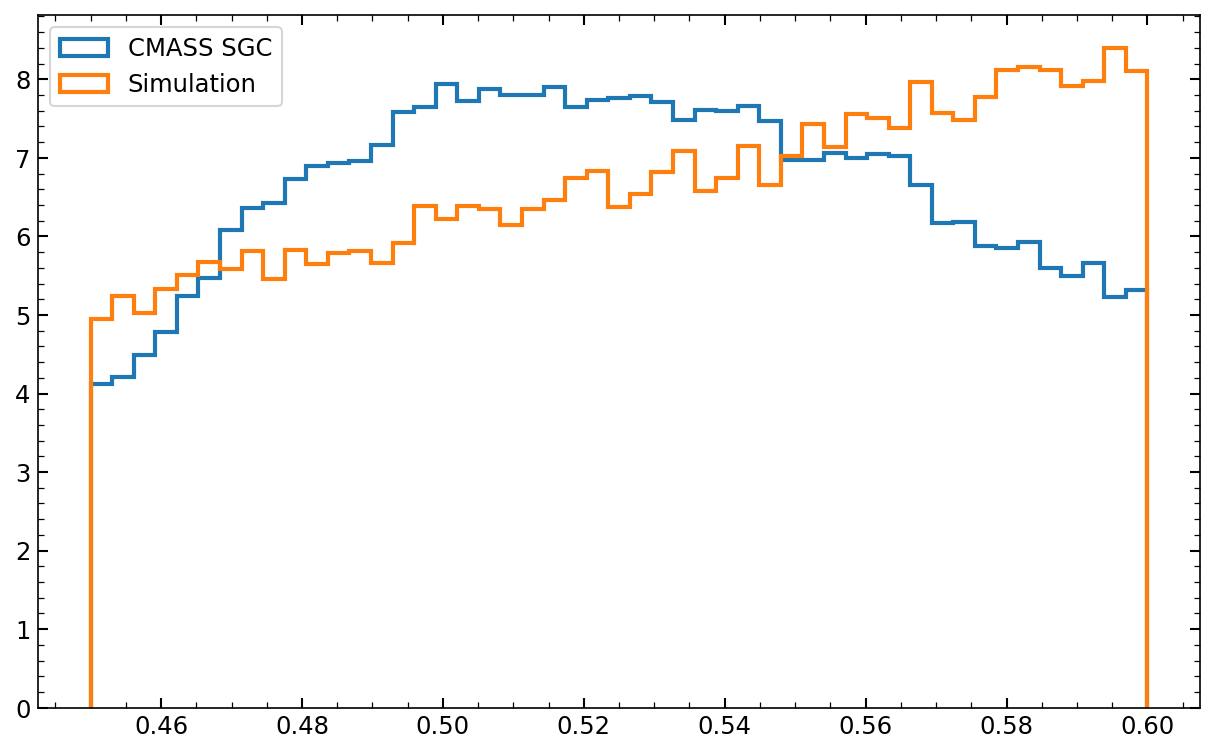

In [47]:
be = np.linspace(0.45, 0.6, 50)
plt.hist(srdz[:, 2], bins=be, histtype='step', label='CMASS SGC',
         color='C0', lw=2, density=True)
plt.hist(rdz[:, 2], bins=be, histtype='step', label='Simulation',
         color='C1', lw=2, density=True)
plt.legend()

In [48]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Convex hull for xyz
hull_xyz = ConvexHull(xyz)
hull_xyz_delaunay = Delaunay(xyz[hull_xyz.vertices])

# Identify which sxyz points are *outside* the convex hull
inside_mask = hull_xyz_delaunay.find_simplex(sxyz) >= 0
outside_points = sxyz[~inside_mask]
inside_points = sxyz[inside_mask]

print(f"{np.sum(~inside_mask)} out of {len(sxyz)} sxyz points are outside the xyz hull.")
percent_inside = np.sum(inside_mask) / len(sxyz) * 100
print(f"{percent_inside:.4f}% of sxyz points are inside the xyz hull.")

1109 out of 557843 sxyz points are outside the xyz hull.
99.8012% of sxyz points are inside the xyz hull.


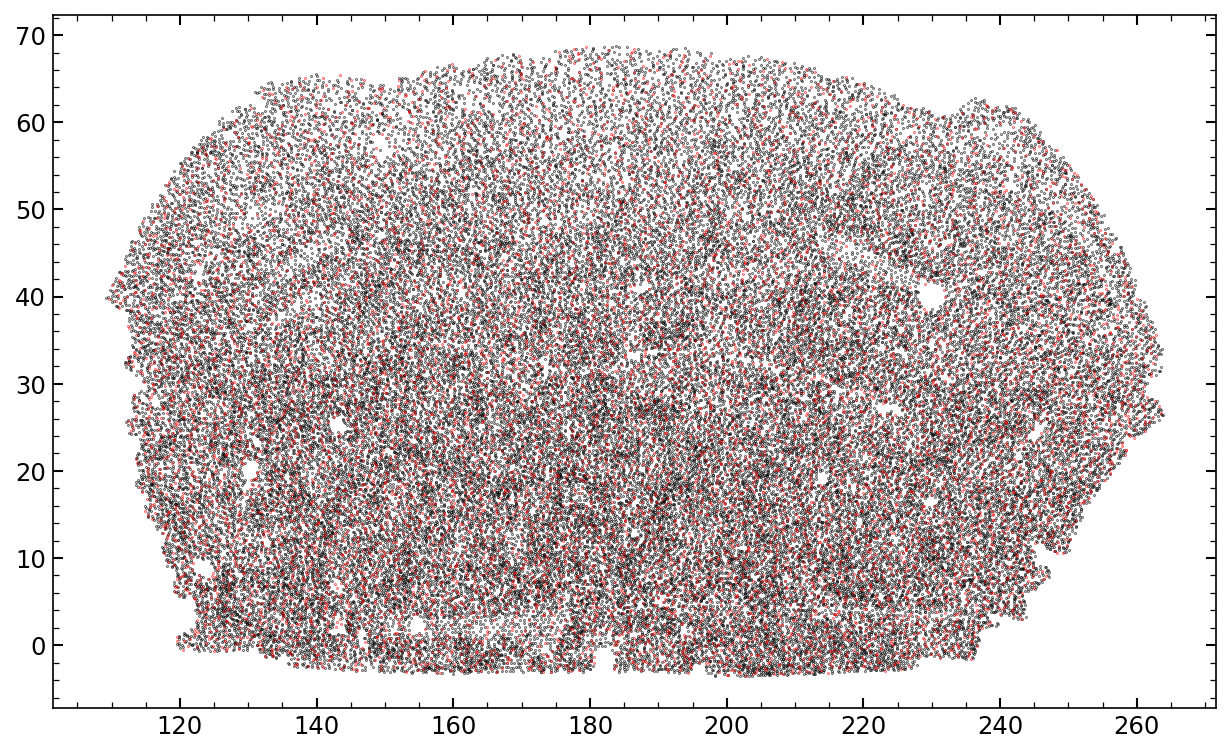

In [49]:
plt.plot(srdz[::10, 0], srdz[::10, 1], 'k.', markersize=0.5)
plt.plot(rdz[::10, 0], rdz[::10, 1], 'r.', markersize=0.5)

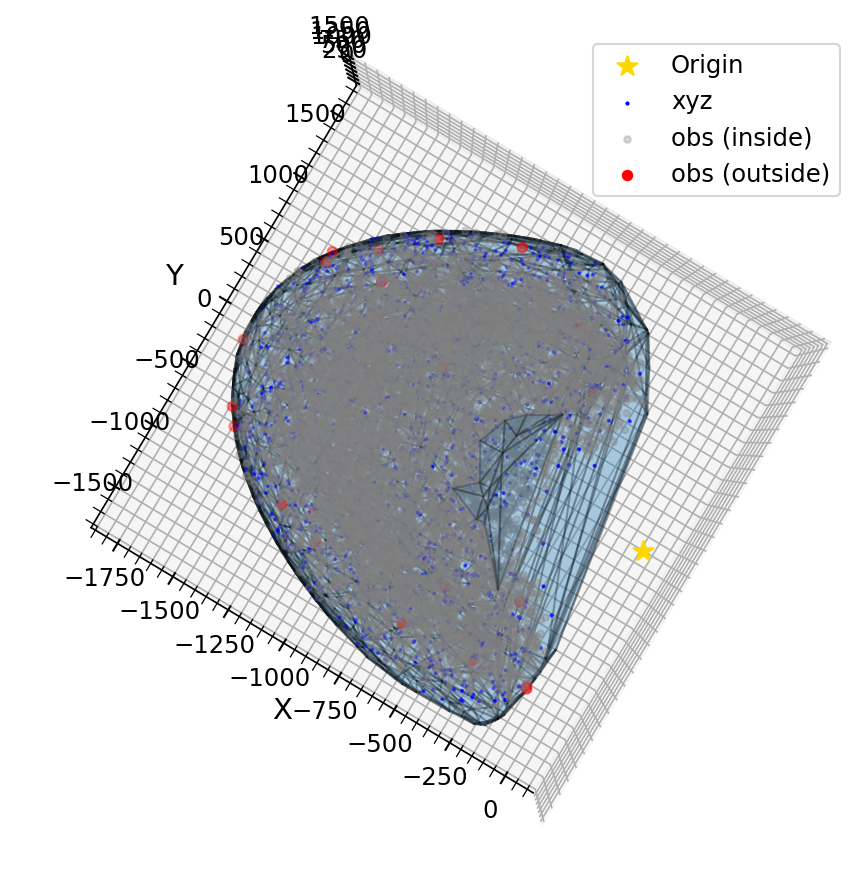

In [50]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot hull of xyz
for simplex in hull_xyz.simplices:
    tri = Poly3DCollection([xyz[simplex]], alpha=0.2)
    tri.set_edgecolor("k")
    ax.add_collection3d(tri)

# Plot xyz and sxyz
ss = 50
ax.scatter(0, 0, 0, color="gold", label="Origin", s=100, marker="*")
ax.scatter(*xyz[::ss].T, color="blue", label="xyz", s=1)
ax.scatter(*inside_points[::ss].T, color="gray",
           label="obs (inside)", s=10, alpha=0.3)
if len(outside_points) > 0:
    ax.scatter(*outside_points[::ss].T, color="red",
               label="obs (outside)", s=20)
ax.legend()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.tight_layout()

# ax.view_init(elev=0, azim=-90)
ax.view_init(elev=90)

plt.show()

## measure for multiple cosmologies

100%|██████████| 9/9 [00:23<00:00,  2.65s/it]


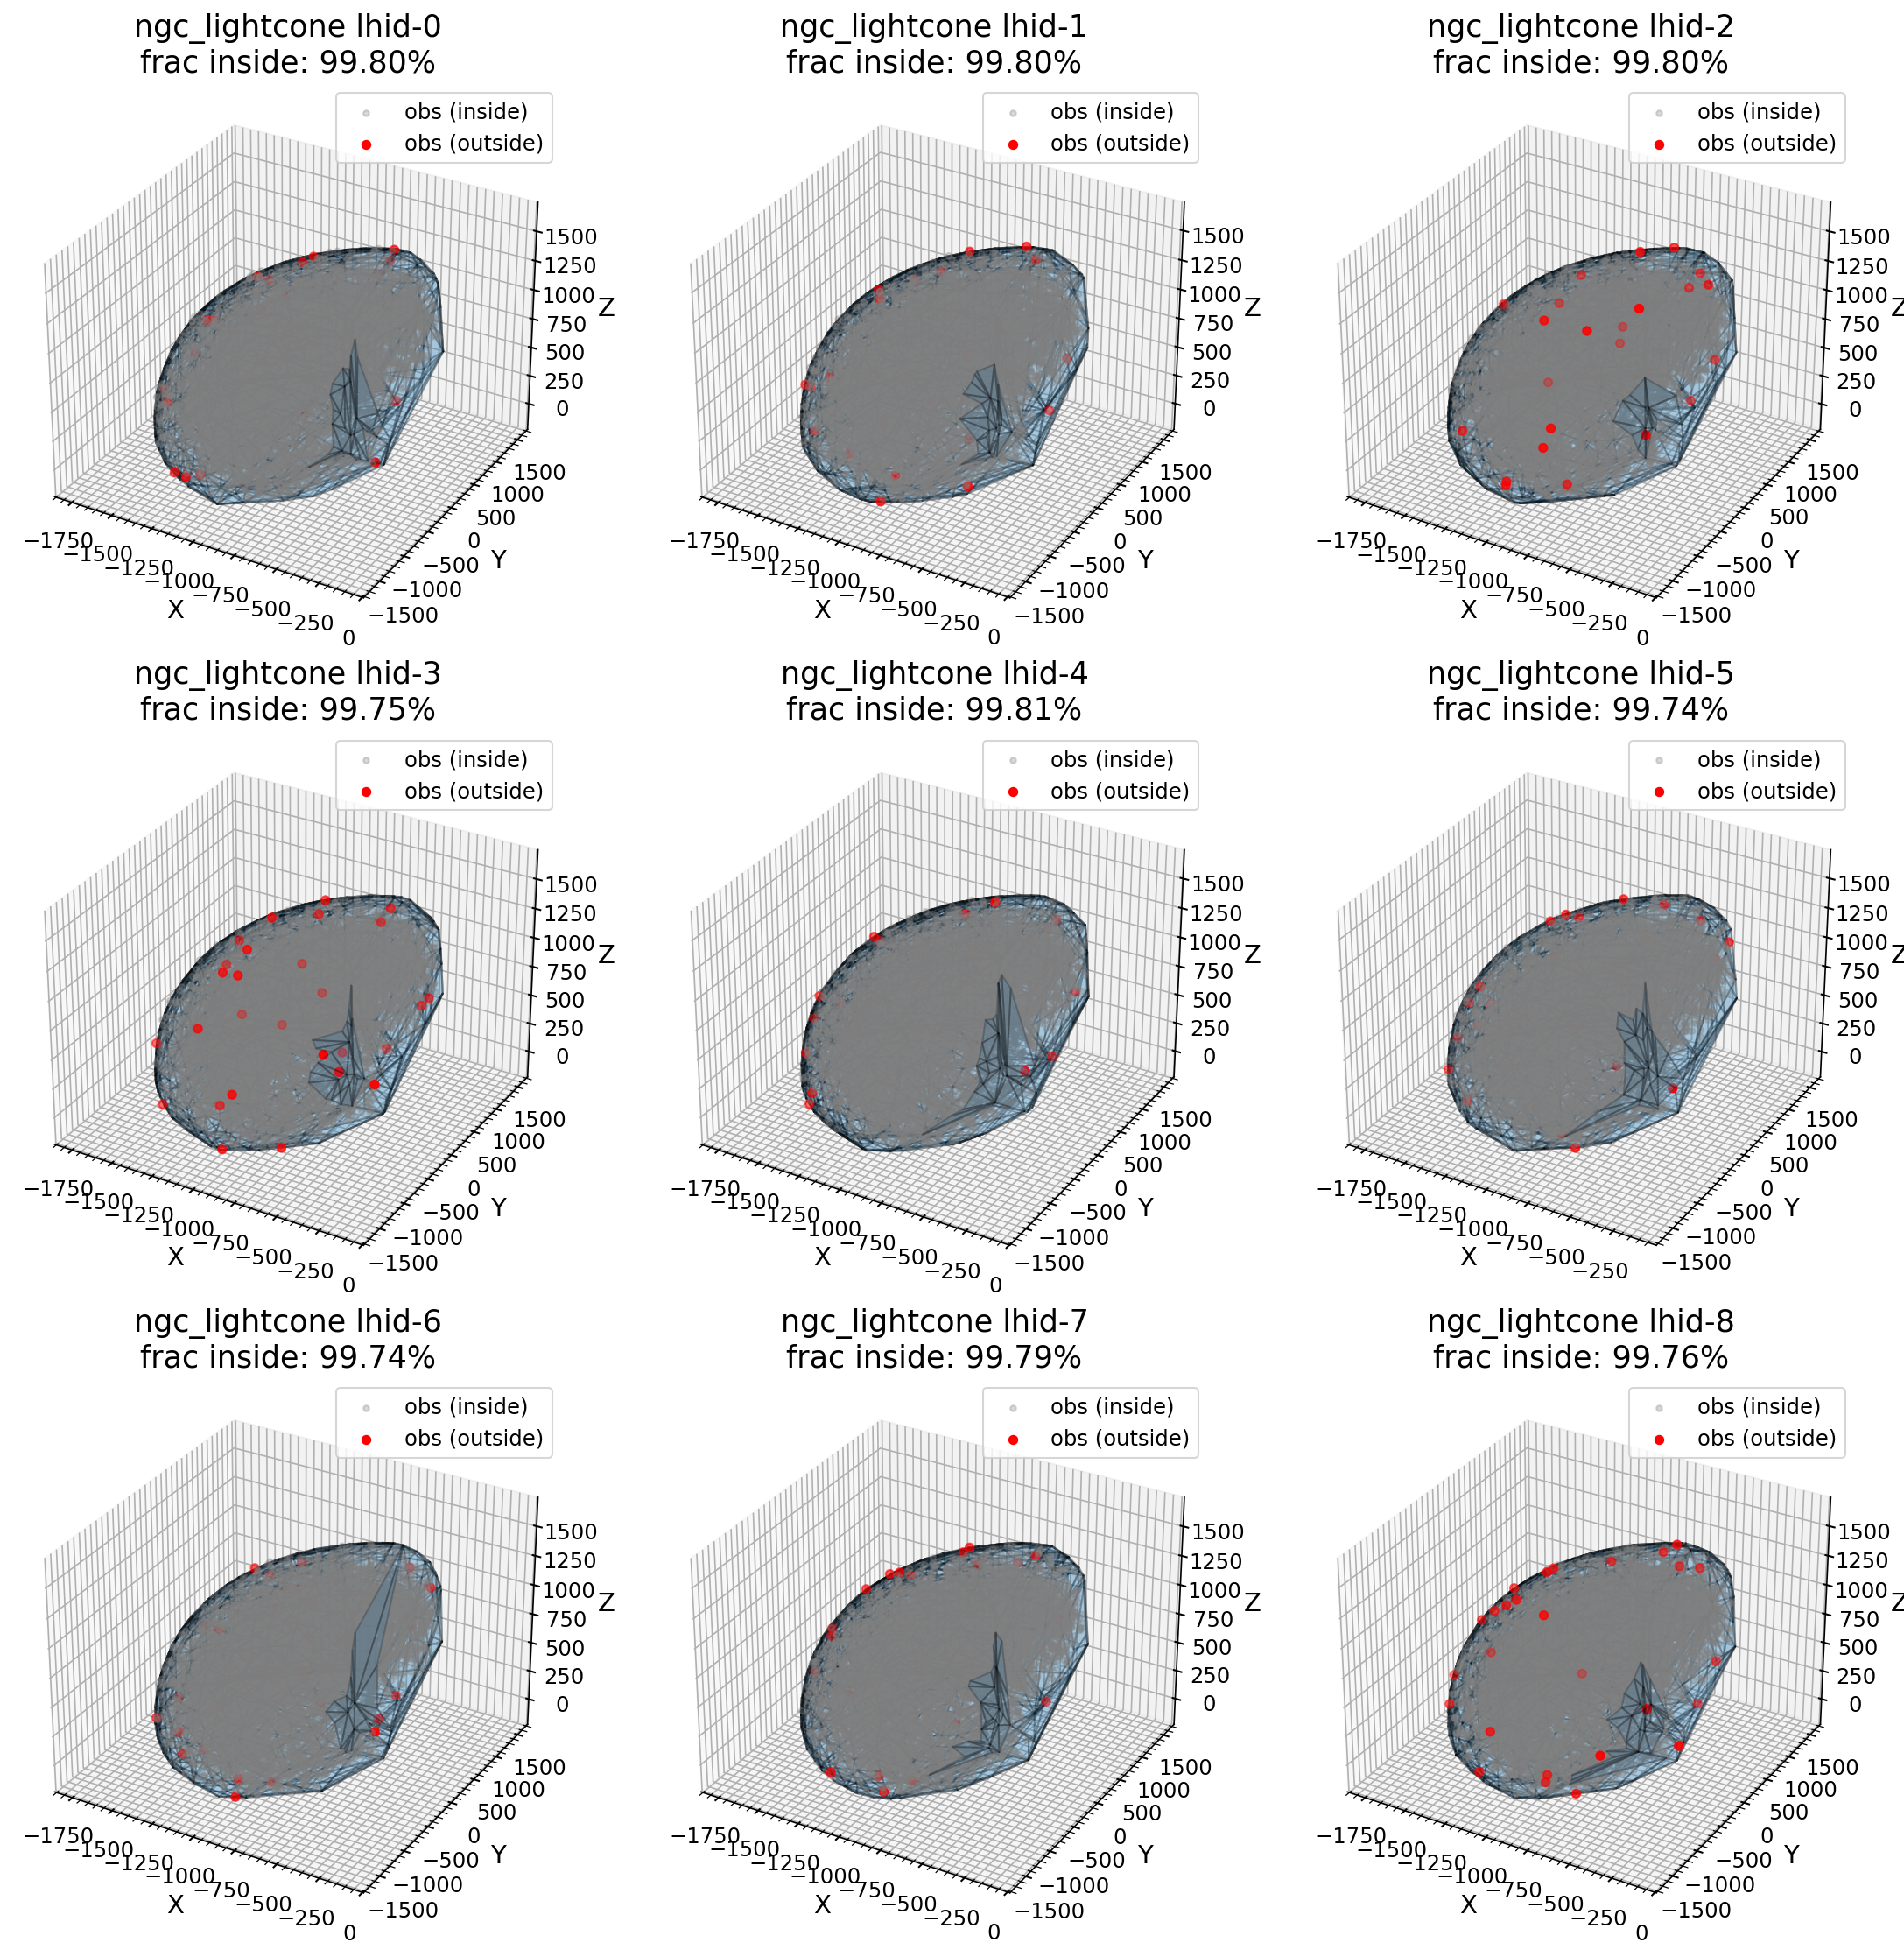

In [53]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

# Plotting

Nsims = 9
W = 3
H = Nsims//W

fig, axs = plt.subplots(
    W, H,
    subplot_kw={'projection': '3d'},
    figsize=(H*5, W*5)
)
axs = axs.flatten()

percentages = []

for lhid in tqdm(range(Nsims)):
    ax = axs[lhid]

    # nbody = 'quijote'
    # sim = 'randoms'
    # tracer = 'simbig_lightcone'
    # L, N = 1000, 128
    # # lhid = 0  # 663
    # hodseed = 0

    simdir = join(wdir, nbody, sim, f'L{L:d}-N{N:d}', str(lhid))

    # cosmo = get_cosmo(simdir)
    cfg = OmegaConf.load(join(simdir, 'config.yaml'))

    filename = join(simdir, tracer, f'hod{hodseed:05}_aug{0:05d}.h5')

    with h5py.File(filename, 'r') as f:
        ra, dec, z = f['ra'][:], f['dec'][:], f['z'][:]
        rdz = np.stack((ra, dec, z), axis=-1)
    xyz = sky_to_xyz(rdz, cosmo)

    # Convex hull for xyz
    hull_xyz = ConvexHull(xyz)
    hull_xyz_delaunay = Delaunay(xyz[hull_xyz.vertices])

    # Identify which sxyz points are *outside* the convex hull
    inside_mask = hull_xyz_delaunay.find_simplex(sxyz) >= 0
    outside_points = sxyz[~inside_mask]
    inside_points = sxyz[inside_mask]

    # Plot hull of xyz
    for simplex in hull_xyz.simplices:
        tri = Poly3DCollection([xyz[simplex]], alpha=0.2)
        tri.set_edgecolor("k")
        ax.add_collection3d(tri)

    # Plot xyz and sxyz
    ss = 50
    # ax.scatter(0, 0, 0, color="gold", label="Origin", s=100, marker="*")
    # ax.scatter(*xyz[::ss].T, color="blue", label="xyz", s=1)
    ax.scatter(*inside_points[::ss].T, color="gray",
               label="obs (inside)", s=10, alpha=0.3)
    if len(outside_points) > 0:
        ax.scatter(*outside_points[::ss].T, color="red",
                   label="obs (outside)", s=20)
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    percent_inside = np.sum(inside_mask) / len(sxyz) * 100
    ax.set_title(f"{tracer} lhid-{lhid}\nfrac inside: {percent_inside:.2f}%")
    # ax.view_init(elev=90)

    percentages.append(percent_inside)

plt.tight_layout()

# ax.view_init(elev=0, azim=-90)

Text(0.5, 0, 'Fraction of points inside convex hull (%)')

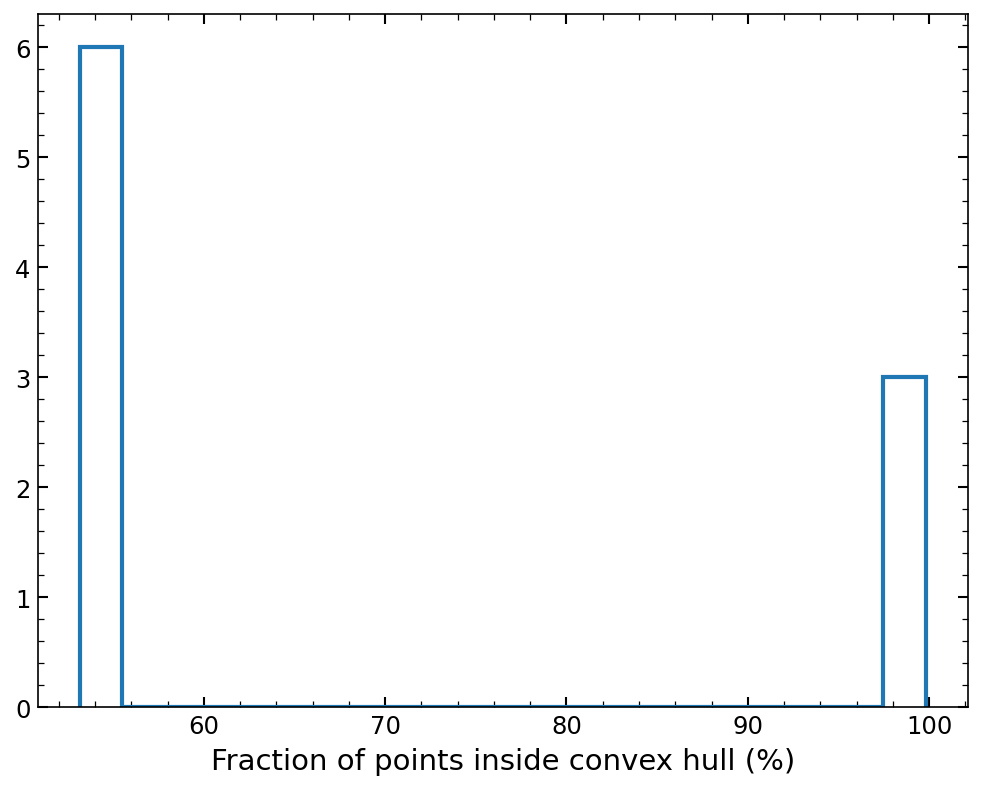

In [52]:
f, ax = plt.subplots(figsize=(8, 6))
ax.hist(percentages, bins=20, histtype='step', lw=2)
ax.set_xlabel("Fraction of points inside convex hull (%)")

## Measure bounding boxes

In [ ]:

def get_minimum_bounding_box(points):
    """
    Find the smallest volume oriented bounding box for a 3D point cloud.
    This is an approximation using the principal components of the points.

    Args:
        points (np.ndarray): A numpy array of shape (N, 3) representing the 3D points.

    Returns:
        tuple: A tuple containing:
            - box_center (np.ndarray): The center of the bounding box (3,).
            - box_extents (np.ndarray): The dimensions of the box (length, width, height) (3,).
            - rotation_matrix (np.ndarray): The rotation matrix to align the box with the coordinate axes (3, 3).
            - corners (np.ndarray): The 8 corner points of the bounding box (8, 3).
    """
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("Input must be a NumPy array with shape (N, 3)")

    if len(points) < 4:
        raise ValueError("At least 4 points are required to define a 3D volume")

    # --- 1. Compute the convex hull of the points ---
    # The minimum bounding box of a set of points is the same as the
    # minimum bounding box of its convex hull. This reduces the number of
    # points we need to consider.
    try:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
    except Exception as e:
        print(f"Could not compute convex hull, using all points. Error: {e}")
        hull_points = points

    # --- 2. Find the principal components (orientation) of the hull points ---
    # The eigenvectors of the covariance matrix give us the principal axes
    # of the point cloud, which we'll use as the orientation for our box.

    # Center the data
    mean_center = np.mean(hull_points, axis=0)
    centered_points = hull_points - mean_center

    # Calculate the covariance matrix
    covariance_matrix = np.cov(centered_points, rowvar=False)

    # Find eigenvectors and eigenvalues
    # eigh is used for symmetric matrices
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # The eigenvectors form the rotation matrix.
    rotation_matrix = eigenvectors.T

    # To ensure a right-handed coordinate system, we check the determinant.
    # If it's -1, we flip one of the axes.
    if np.linalg.det(rotation_matrix) < 0:
        rotation_matrix[0, :] *= -1

    # --- 3. Transform points to the new coordinate system ---
    # We rotate the points so that their principal axes align with the
    # world coordinate axes.
    transformed_points = rotation_matrix @ centered_points.T
    transformed_points = transformed_points.T

    # --- 4. Find the axis-aligned bounding box in the new coordinate system ---
    min_coords = np.min(transformed_points, axis=0)
    max_coords = np.max(transformed_points, axis=0)

    # The extents (dimensions) of the box
    box_extents = max_coords - min_coords

    # The center of the box in the transformed space
    transformed_center = (min_coords + max_coords) / 2

    # --- 5. Transform the box center and corners back to the original space ---
    box_center = mean_center + rotation_matrix.T @ transformed_center

    # Generate the 8 corners of the box in the transformed space
    corners_transformed = np.array([
        [min_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], min_coords[1], min_coords[2]],
        [min_coords[0], max_coords[1], min_coords[2]],
        [max_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], min_coords[1], max_coords[2]],
        [min_coords[0], max_coords[1], max_coords[2]],
        [max_coords[0], max_coords[1], max_coords[2]],
    ])

    # Rotate the corners back to the original coordinate system
    corners = (rotation_matrix.T @ corners_transformed.T).T + mean_center

    # return box_center, box_extents, rotation_matrix.T, corners
    return corners


def plot_bounding_box(corners, ax):
    """
    Plots the 3D points and their oriented bounding box.
    """

    # Define the 12 edges of the cube
    edges = [
        (0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 3),
        (2, 6), (3, 7), (4, 5), (4, 6), (5, 7), (6, 7)
    ]

    # Plot the edges of the bounding box
    for i, j in edges:
        ax.plot([corners[i, 0], corners[j, 0]],
                [corners[i, 1], corners[j, 1]],
                [corners[i, 2], corners[j, 2]], c='r')

    # Define the 6 faces of the cube
    faces = [
        [corners[0], corners[1], corners[3], corners[2]],
        [corners[4], corners[5], corners[7], corners[6]],
        [corners[0], corners[1], corners[5], corners[4]],
        [corners[2], corners[3], corners[7], corners[6]],
        [corners[0], corners[2], corners[6], corners[4]],
        [corners[1], corners[3], corners[7], corners[5]]
    ]

    # Plot the faces with some transparency
    ax.add_collection3d(Poly3DCollection(
        faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

--- Bounding Box Info ---
Center: [1.06 2.46 0.5 ]
Dimensions (Extents): [0.96 1.96 4.94]
Volume: 9.29
Rotation Matrix (Orientation):
[[-0.   -0.7  -0.72]
 [ 0.02  0.72 -0.7 ]
 [ 1.   -0.02  0.01]]


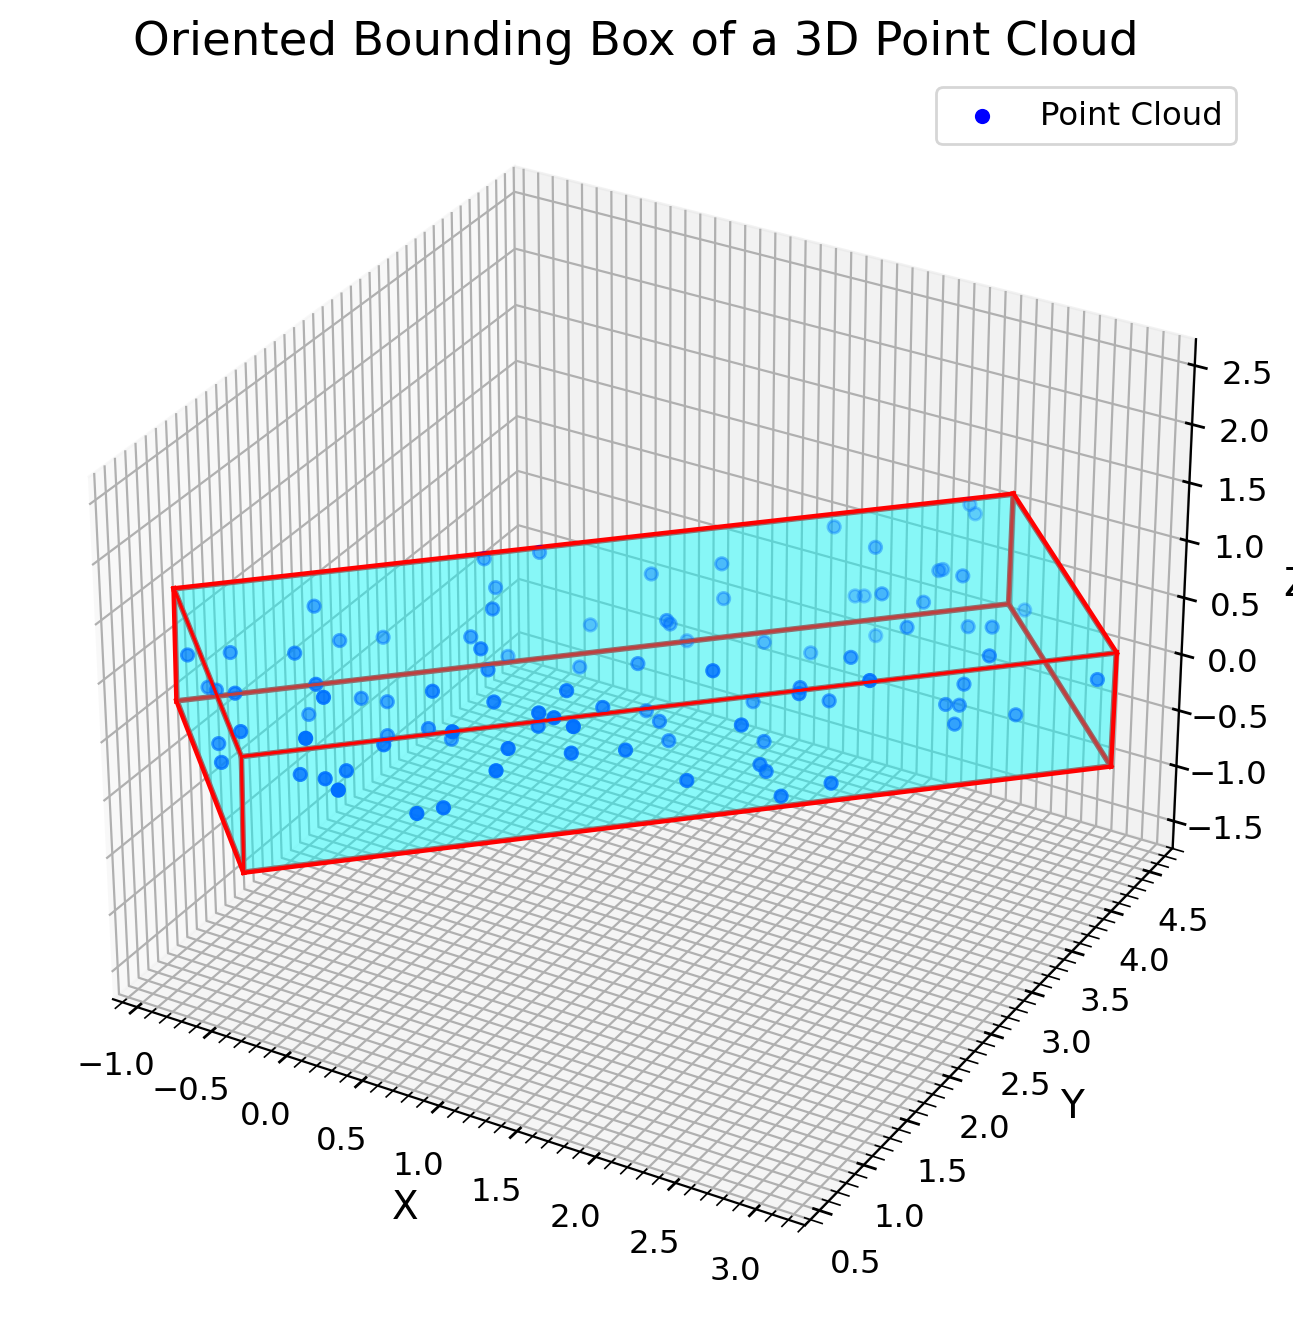

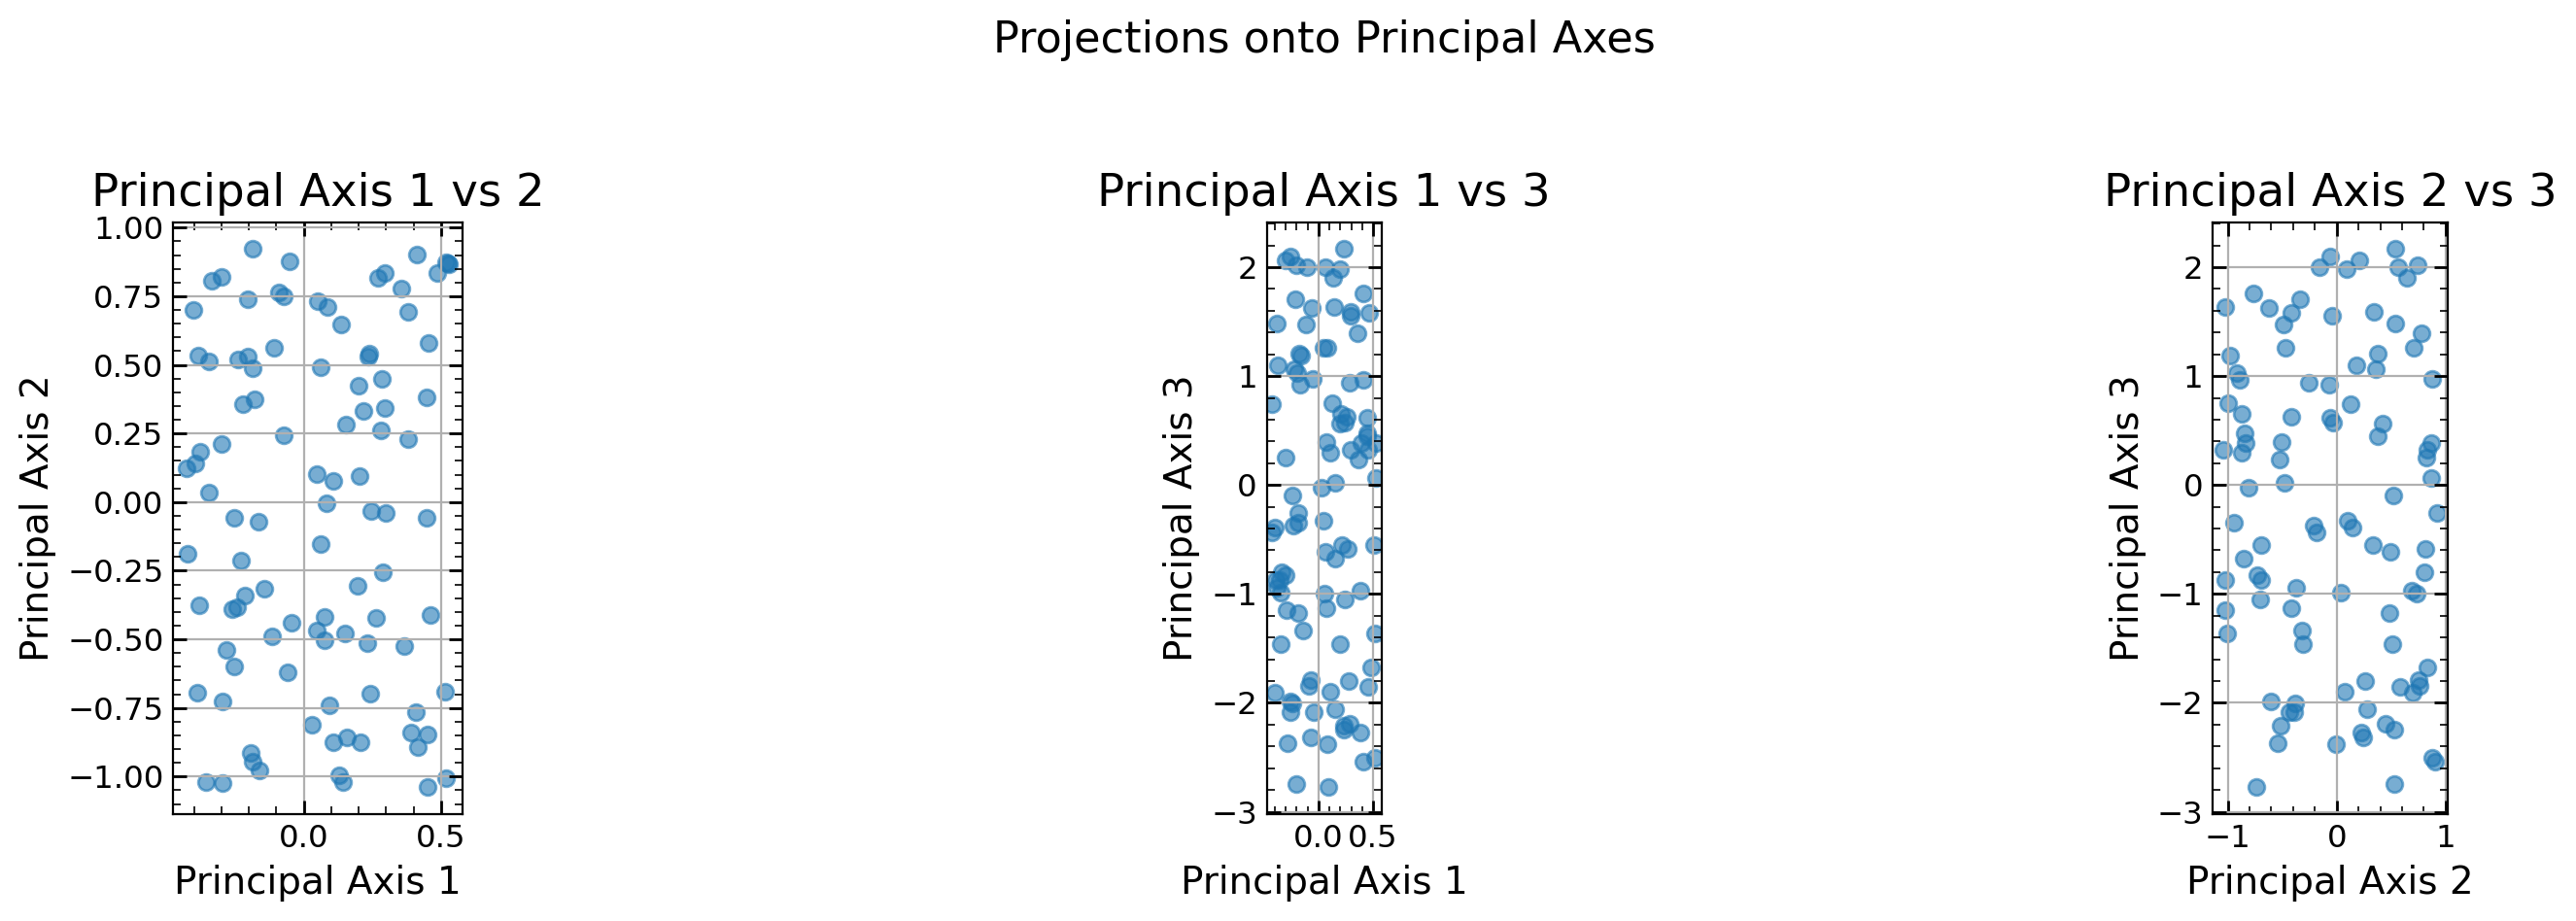

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def get_minimum_bounding_box(points):
    """
    Find the smallest volume oriented bounding box for a 3D point cloud.
    This is an approximation using the principal components of the points.

    Args:
        points (np.ndarray): A numpy array of shape (N, 3) representing the 3D points.

    Returns:
        tuple: A tuple containing:
            - box_center (np.ndarray): The center of the bounding box (3,).
            - box_extents (np.ndarray): The dimensions of the box (length, width, height) (3,).
            - rotation_matrix (np.ndarray): The rotation matrix to align the box with the coordinate axes (3, 3).
            - corners (np.ndarray): The 8 corner points of the bounding box (8, 3).
            - cloud_mean (np.ndarray): The mean of the hull points, used as the pivot for rotation (3,).
    """
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("Input must be a NumPy array with shape (N, 3)")

    if len(points) < 4:
        raise ValueError("At least 4 points are required to define a 3D volume")

    # --- 1. Compute the convex hull of the points ---
    try:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
    except Exception as e:
        print(f"Could not compute convex hull, using all points. Error: {e}")
        hull_points = points

    # --- 2. Find the principal components (orientation) of the hull points ---
    mean_center = np.mean(hull_points, axis=0)
    centered_points = hull_points - mean_center
    covariance_matrix = np.cov(centered_points, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    rotation_matrix = eigenvectors.T
    if np.linalg.det(rotation_matrix) < 0:
        rotation_matrix[0, :] *= -1

    # --- 3. Transform points to the new coordinate system ---
    transformed_points = rotation_matrix @ centered_points.T
    transformed_points = transformed_points.T

    # --- 4. Find the axis-aligned bounding box in the new coordinate system ---
    min_coords = np.min(transformed_points, axis=0)
    max_coords = np.max(transformed_points, axis=0)
    box_extents = max_coords - min_coords
    transformed_center = (min_coords + max_coords) / 2

    # --- 5. Transform the box center and corners back to the original space ---
    box_center = mean_center + rotation_matrix.T @ transformed_center
    corners_transformed = np.array([
        [min_coords[0], min_coords[1], min_coords[2]], [
            max_coords[0], min_coords[1], min_coords[2]],
        [min_coords[0], max_coords[1], min_coords[2]], [
            max_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], min_coords[1], max_coords[2]], [
            max_coords[0], min_coords[1], max_coords[2]],
        [min_coords[0], max_coords[1], max_coords[2]], [
            max_coords[0], max_coords[1], max_coords[2]],
    ])
    corners = (rotation_matrix.T @ corners_transformed.T).T + mean_center

    return box_center, box_extents, rotation_matrix.T, corners, mean_center


def plot_bounding_box(points, corners):
    """
    Plots the 3D points and their oriented bounding box.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
               c='b', marker='o', label='Point Cloud')
    edges = [
        (0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 3),
        (2, 6), (3, 7), (4, 5), (4, 6), (5, 7), (6, 7)
    ]
    for i, j in edges:
        ax.plot([corners[i, 0], corners[j, 0]], [corners[i, 1],
                corners[j, 1]], [corners[i, 2], corners[j, 2]], c='r')
    faces = [
        [corners[0], corners[1], corners[3], corners[2]], [
            corners[4], corners[5], corners[7], corners[6]],
        [corners[0], corners[1], corners[5], corners[4]], [
            corners[2], corners[3], corners[7], corners[6]],
        [corners[0], corners[2], corners[6], corners[4]], [
            corners[1], corners[3], corners[7], corners[5]]
    ]
    ax.add_collection3d(Poly3DCollection(
        faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Oriented Bounding Box of a 3D Point Cloud')
    ax.legend()
    max_range = np.array([points[:, 0].max()-points[:, 0].min(), points[:, 1].max() -
                         points[:, 1].min(), points[:, 2].max()-points[:, 2].min()]).max() / 2.0
    mid_x = (points[:, 0].max()+points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max()+points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max()+points[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    # plt.show() is called after all plots are set up


def plot_projections(points, cloud_mean, rotation_matrix):
    """
    Projects the 3D points onto the 2D planes defined by the principal axes.

    Args:
        points (np.ndarray): The original 3D points.
        cloud_mean (np.ndarray): The mean of the points, used for centering.
        rotation_matrix (np.ndarray): The rotation matrix defining the principal axes.
    """
    # The rotation matrix returned by get_minimum_bounding_box transforms from the
    # principal axes system back to the original system. Its transpose does the opposite.
    rot_to_principal = rotation_matrix.T

    # Center the points and transform them to the principal axes coordinate system
    centered_points = points - cloud_mean
    transformed_points = (rot_to_principal @ centered_points.T).T

    # Create the 2D projection plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Projections onto Principal Axes', fontsize=16)

    # Projection onto Plane 1-2
    axs[0].scatter(transformed_points[:, 0],
                   transformed_points[:, 1], alpha=0.6)
    axs[0].set_title('Principal Axis 1 vs 2')
    axs[0].set_xlabel('Principal Axis 1')
    axs[0].set_ylabel('Principal Axis 2')
    axs[0].grid(True)
    axs[0].set_aspect('equal', adjustable='box')

    # Projection onto Plane 1-3
    axs[1].scatter(transformed_points[:, 0],
                   transformed_points[:, 2], alpha=0.6)
    axs[1].set_title('Principal Axis 1 vs 3')
    axs[1].set_xlabel('Principal Axis 1')
    axs[1].set_ylabel('Principal Axis 3')
    axs[1].grid(True)
    axs[1].set_aspect('equal', adjustable='box')

    # Projection onto Plane 2-3
    axs[2].scatter(transformed_points[:, 1],
                   transformed_points[:, 2], alpha=0.6)
    axs[2].set_title('Principal Axis 2 vs 3')
    axs[2].set_xlabel('Principal Axis 2')
    axs[2].set_ylabel('Principal Axis 3')
    axs[2].grid(True)
    axs[2].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.show() is called after all plots are set up


if __name__ == '__main__':
    # --- Example Usage ---
    np.random.seed(42)
    angle = np.pi / 4
    rot_mat = np.array([[np.cos(angle), -np.sin(angle), 0],
                       [np.sin(angle), np.cos(angle), 0], [0, 0, 1]])
    raw_points = np.random.rand(100, 3)
    raw_points[:, 0] *= 5
    raw_points[:, 1] *= 2
    points_3d = raw_points @ rot_mat.T

    # Find the minimum bounding box
    center, extents, rotation, corners, cloud_mean = get_minimum_bounding_box(
        points_3d)

    # Print the results
    print("--- Bounding Box Info ---")
    print(f"Center: {np.round(center, 2)}")
    print(f"Dimensions (Extents): {np.round(extents, 2)}")
    print(f"Volume: {np.round(np.prod(extents), 2)}")
    print("Rotation Matrix (Orientation):")
    print(np.round(rotation, 2))

    # Visualize the 3D box
    plot_bounding_box(points_3d, corners)

    # Visualize the 2D projections
    plot_projections(points_3d, cloud_mean, rotation)

    # Show all plots
    plt.show()

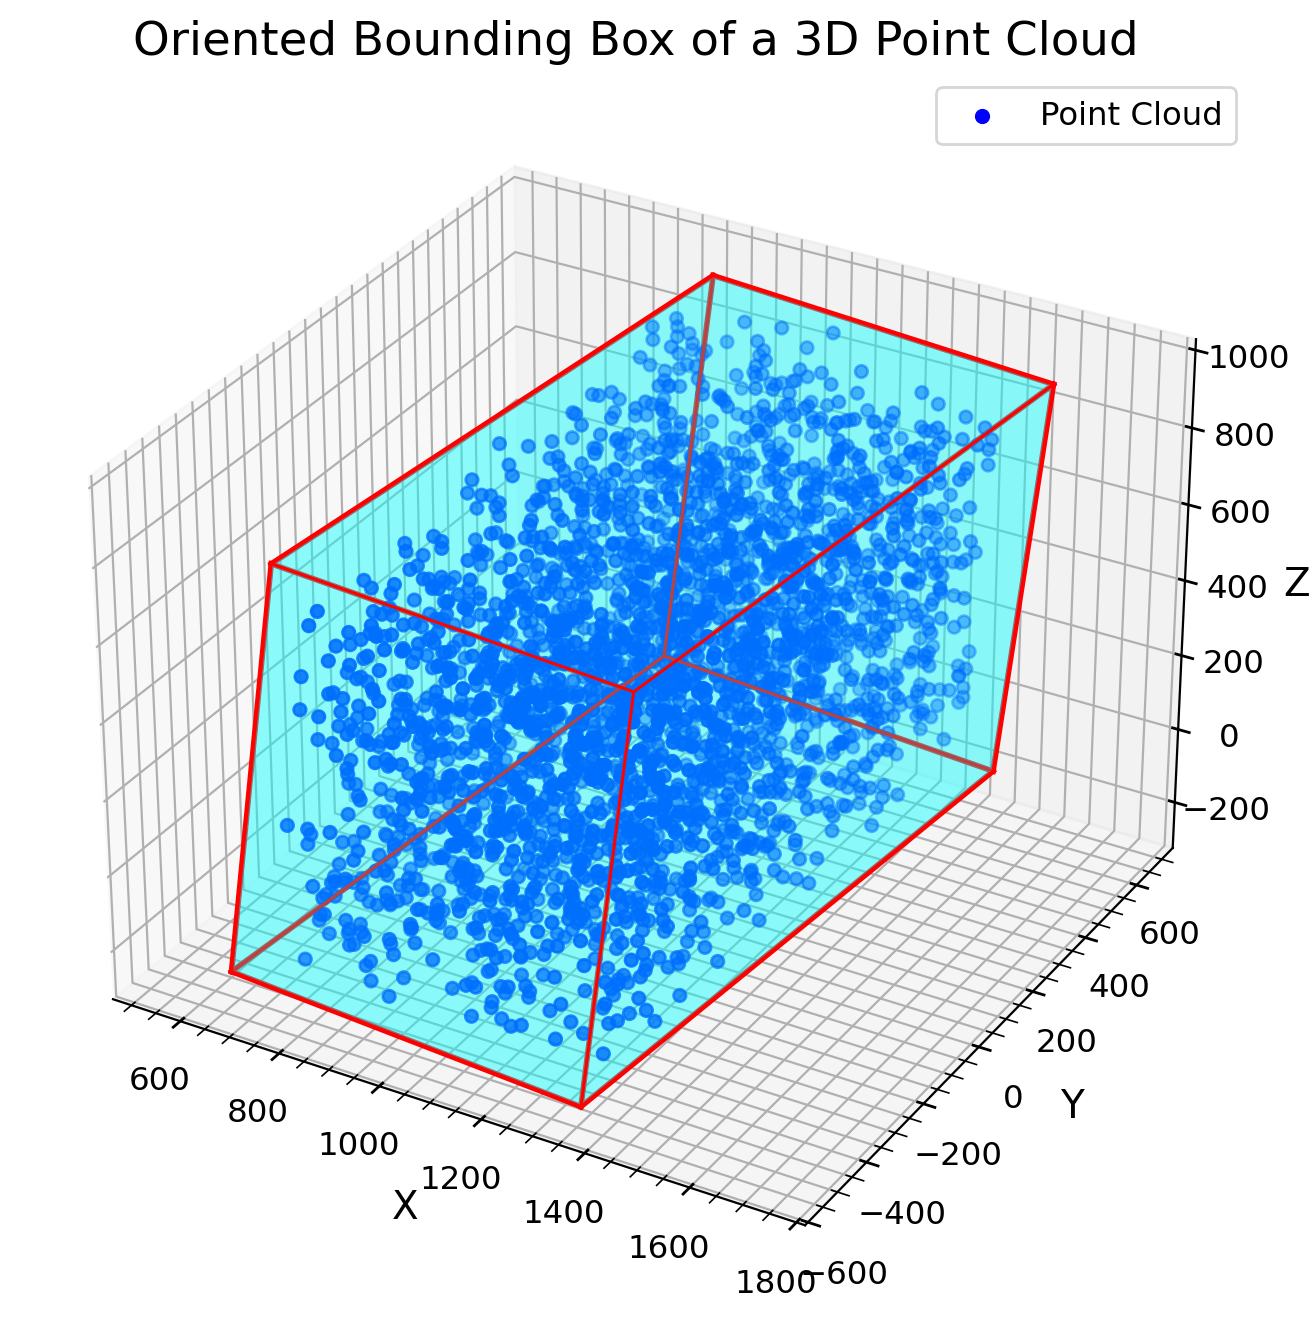

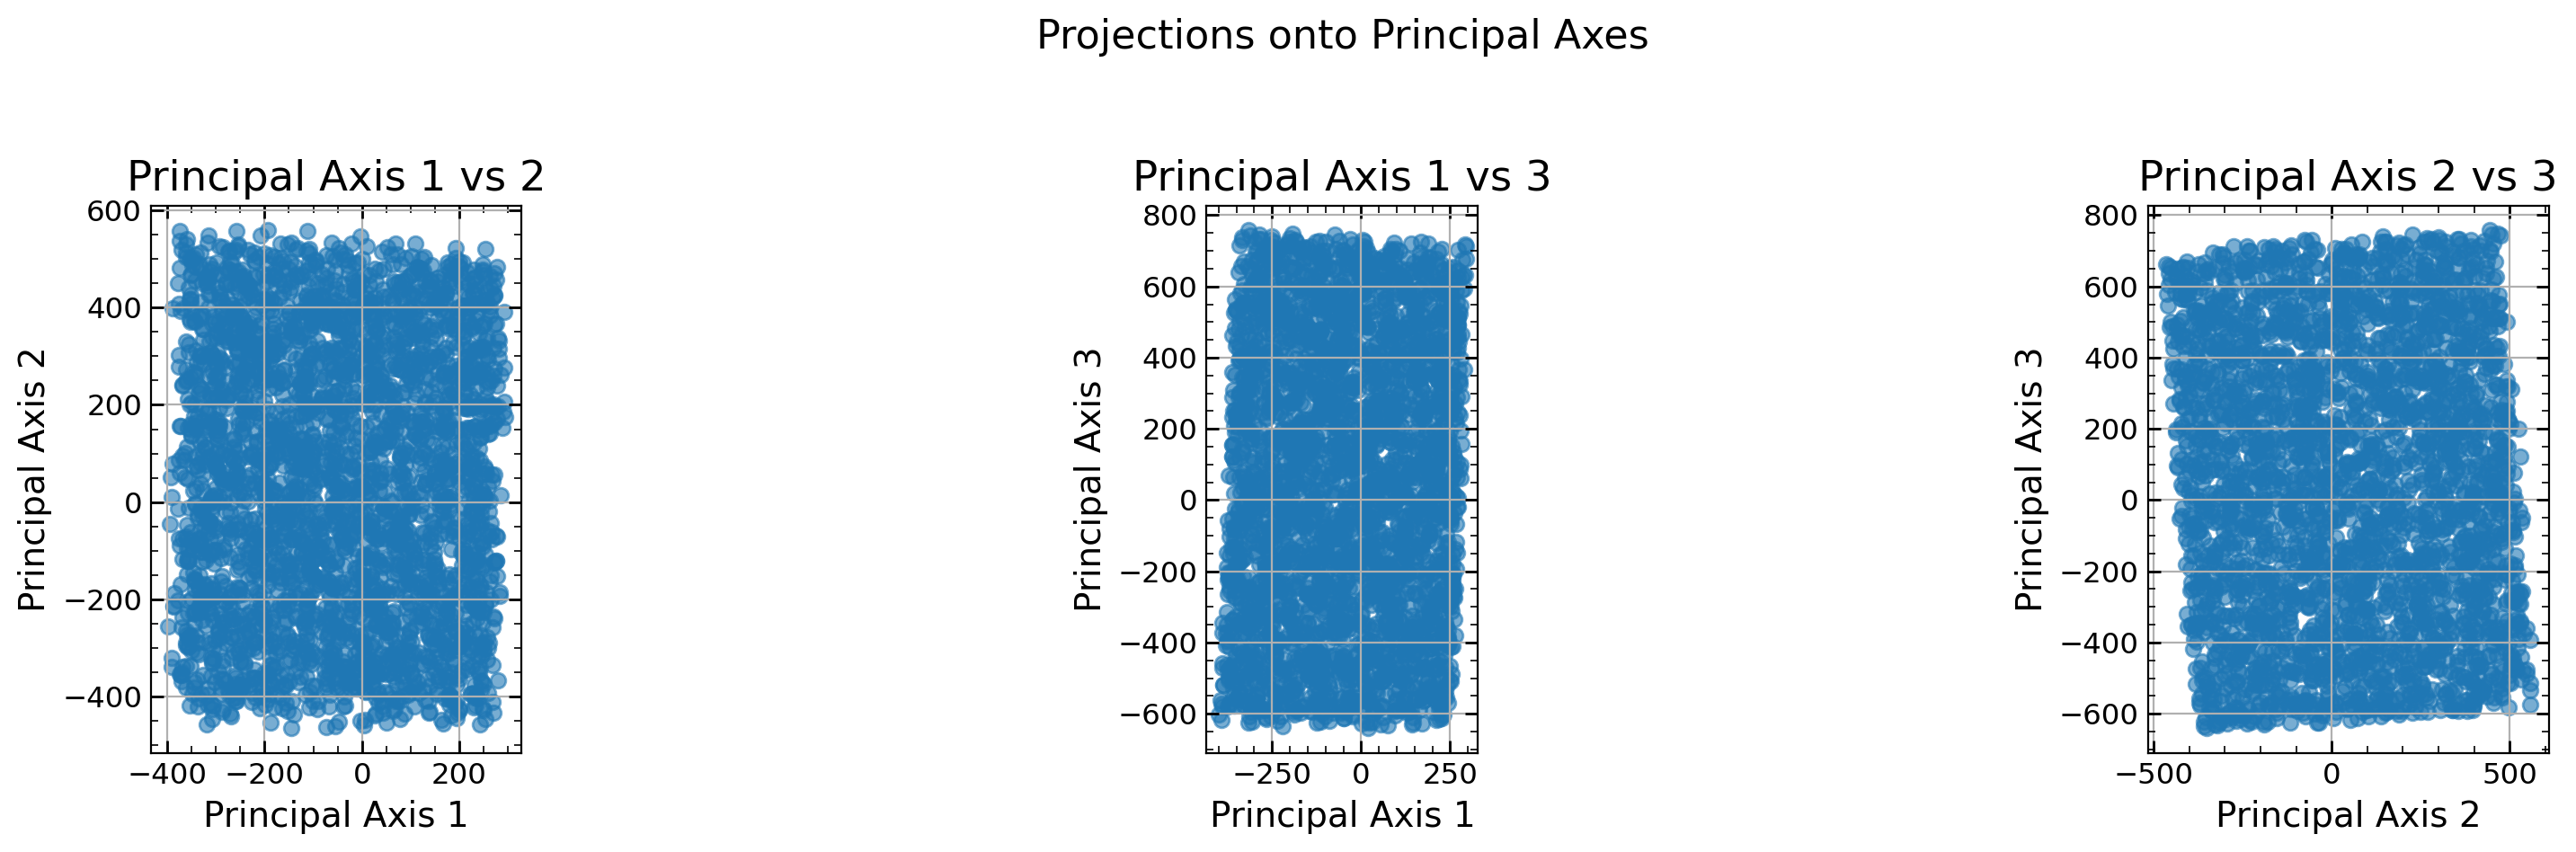

In [ ]:
points_3d = xyz[::100]
center, extents, rotation, corners, cloud_mean = get_minimum_bounding_box(
    points_3d)
# Visualize the 3D box
plot_bounding_box(points_3d, corners)

# Visualize the 2D projections
plot_projections(points_3d, cloud_mean, rotation)


Plotting remapped box for Case 2 (MTNG - Identity)...


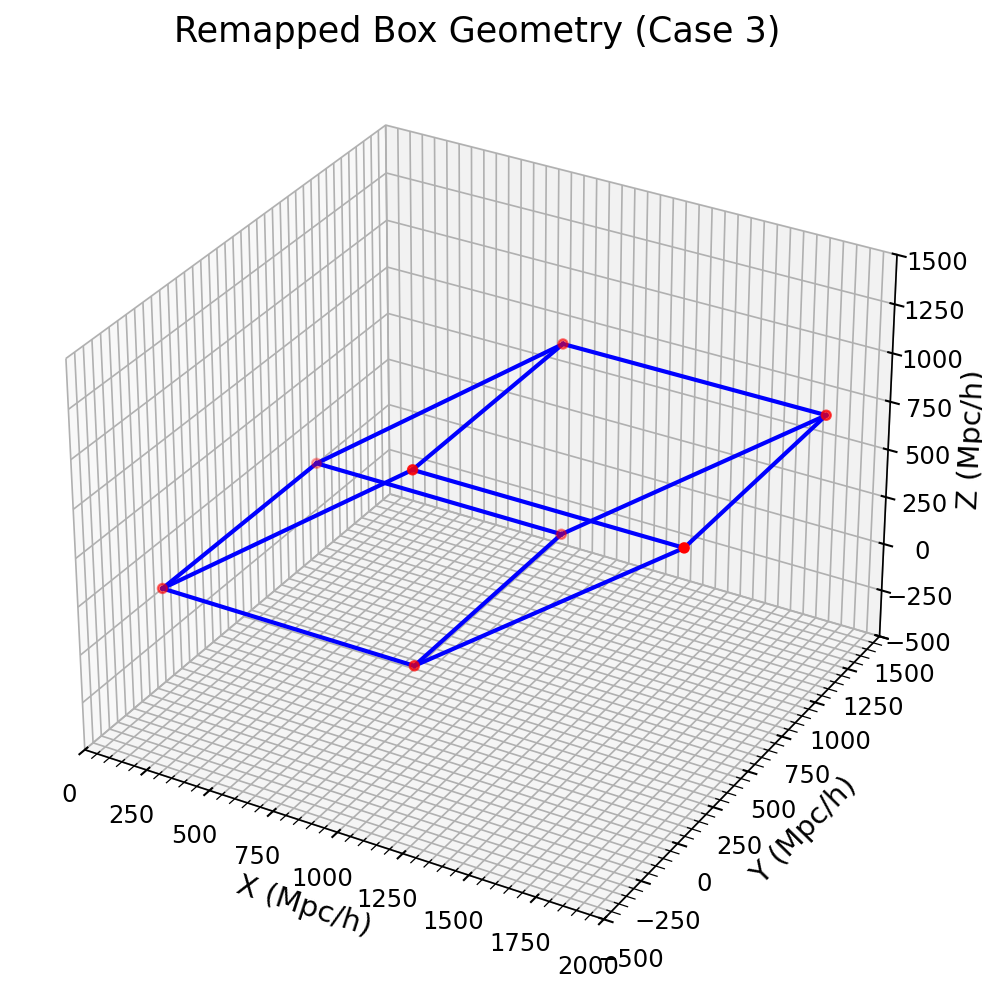

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def get_geometry(remap_case):
    """
    Stores and retrieves the geometry information from the C++ code.
    """
    # Transformation matrices for the cuboid remapping.
    # Corresponds to Geometry::remaps
    remap_matrices = [
        # Case 0 (NGC)
        np.array([[1, 1, 0],
                  [0, 0, 1],
                  [1, 0, 0]]),
        # Case 1 (NGC)
        np.array([[1, 1, 1],
                  [1, 0, 0],
                  [0, 1, 0]]),
        # Case 2 (MTNG - Identity)
        np.array([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]]),
        # Case 3 (SGC)
        np.array([[1, 1, 0],
                  [0, 0, 1],
                  [1, 0, 0]]),
        # Case 4 (SIMBIG)
        np.array([[1, 1, 0],
                  [0, 0, 1],
                  [1, 0, 0]]),
    ]

    if not (0 <= remap_case < len(remap_matrices)):
        raise ValueError(
            f"remap_case must be between 0 and {len(remap_matrices)-1}")

    return remap_matrices[remap_case]


def remap_snapshot(xhlo, remap_case):
    """
    Python equivalent of the remapping performed in the C++ `remap_snapshot` function.
    This function takes halo positions and applies the cuboid transformation.

    Args:
        xhlo (np.ndarray): A (N, 3) array of halo positions.
        remap_case (int): The index for the geometry to use.

    Returns:
        np.ndarray: The remapped halo positions.
    """
    remap_matrix = get_geometry(remap_case)
    # The C++ code's use of per_unit and scaling back up is equivalent to
    # a direct matrix multiplication on the coordinates.
    # np.dot(xhlo, remap_matrix.T) is equivalent to (remap_matrix @ xhlo.T).T
    return np.dot(xhlo, remap_matrix.T)


def plot_remapped_box(box_size, remap_case):
    """
    Generates a 3D plot of the simulation box after remapping.
    """
    # 1. Define the 8 corners of the original simulation box (0 to box_size)
    corners = np.array([
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
        [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]
    ]) * box_size

    # 2. Apply the remapping transformation to the corners
    remapped_corners = remap_snapshot(corners, remap_case)

    # 3. Define the 12 edges of the cube by connecting corner indices
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
        (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
        (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
    ]

    # 4. Create the 3D plot
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the edges of the remapped box
    for start, end in edges:
        points = np.vstack([remapped_corners[start], remapped_corners[end]])
        ax.plot(points[:, 0], points[:, 1], points[:, 2], 'b-')

    # Plot the corners of the remapped box
    ax.scatter(remapped_corners[:, 0], remapped_corners[:, 1],
               remapped_corners[:, 2], c='r', marker='o')

    # Set axis labels and title
    ax.set_xlabel('X (Mpc/h)')
    ax.set_ylabel('Y (Mpc/h)')
    ax.set_zlabel('Z (Mpc/h)')
    ax.set_title(f'Remapped Box Geometry (Case {remap_case})')

    # Enforce equal aspect ratio for a true-to-scale view
    max_range = np.array([
        remapped_corners[:, 0].max() - remapped_corners[:, 0].min(),
        remapped_corners[:, 1].max() - remapped_corners[:, 1].min(),
        remapped_corners[:, 2].max() - remapped_corners[:, 2].min()
    ]).max() / 2.0

    mid_x = (remapped_corners[:, 0].max() + remapped_corners[:, 0].min()) * 0.5
    mid_y = (remapped_corners[:, 1].max() + remapped_corners[:, 1].min()) * 0.5
    mid_z = (remapped_corners[:, 2].max() + remapped_corners[:, 2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()


if __name__ == '__main__':
    BOX_SIZE = 1000.0
    # Plot for Case 2 (Identity, should be a normal cube)
    print("\nPlotting remapped box for Case 2 (MTNG - Identity)...")
    plot_remapped_box(BOX_SIZE, remap_case=3)